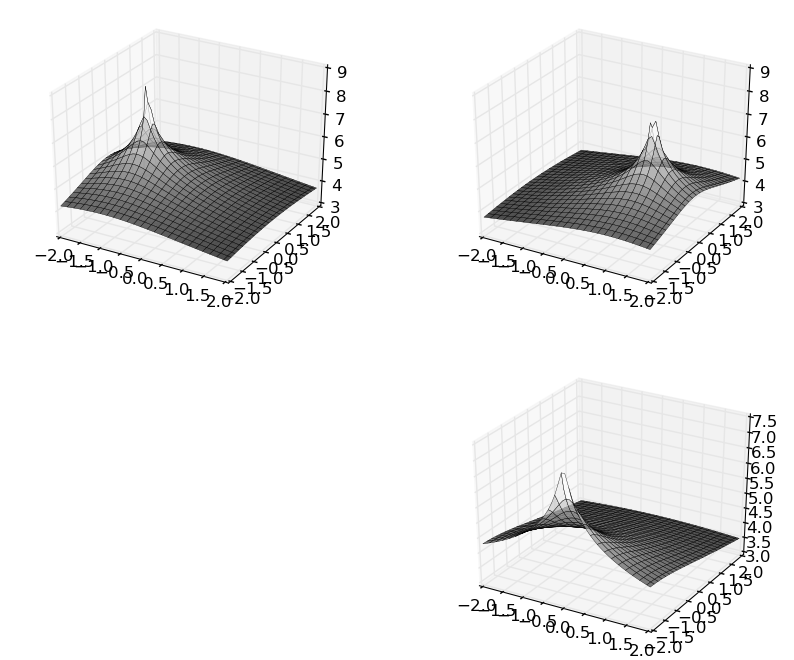

In [1]:
using PyPlot

n = 50
xn = yn = n
x = linspace(-2, 2, xn)
y = linspace(-2, 2, yn)

xgrid = repmat(x, 1, xn)';
ygrid = repmat(y, 1, yn);

type Antenna
    x::Float64
    y::Float64
end

# 
#          _
#          |
#    X(1)--+--X(2)
#          |
#         X(3)
#

antennas = Antenna[]
push!(antennas, Antenna(-1, 0))
push!(antennas, Antenna(1, 0))
push!(antennas, Antenna(0, -2))

# vectorized
fi(a, x, y) = 1./((x.-antennas[a].x).^2 .+ (y.-antennas[a].y).^2 + .1)
flogv(a, x, y) = 5-log((x.-antennas[a].x).^2 .+ (y.-antennas[a].y + .1).^2)/2

fig = figure("An example", figsize=(10,8));

ax = fig[:add_subplot](2,2,1, projection = "3d");
z = flogv(1,xgrid,ygrid)
ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.7, linewidth=0.25)

ax = fig[:add_subplot](2,2,2, projection = "3d");
z = flogv(2,xgrid,ygrid)
ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.7, linewidth=0.25)

ax = fig[:add_subplot](2,2,3, projection = "3d");
z = flogv(3,xgrid,ygrid)
ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.7, linewidth=0.25)
# fig[:subplots_adjust](left=.1,right=.9,top=.9,bottom=.1,wspace=.1,hspace=.1);
# show();


In [1]:
using ANN

type Antenna
    x::Float64
    y::Float64
end

# 
#          _
#          |
#      X1--+--X2
#          |
#         X3
#

antennas = Antenna[]
push!(antennas, Antenna(-1, 0))
push!(antennas, Antenna(1, 0))
push!(antennas, Antenna(0, -2))

fi(a, x, y) = 1 / ((x-antennas[a].x)^2 + (y-antennas[a].y)^2 + 1)
flog(a, x, y) = 5-log((x-antennas[a].x)^2 + (y-antennas[a].y + .1)^2)/2
# vectorized
flogv(a, x, y) = 5-log((x.-antennas[a].x).^2 .+ (y.-antennas[a].y + .1).^2)/2

N_set = 100
X_test = ones(N_set, 3)

# Kinda like a C struct
type StandardScalar
    mean::Vector{Float64}
    std::Vector{Float64}
end

# Helper function to initialize an empty scalar
function StandardScalar()
    StandardScalar(Array(Float64,0),Array(Float64,0))
end

# Compute mean and standard deviation of each column
function fit_std_scalar!(std_scalar::StandardScalar,X::Matrix{Float64})
    n_rows, n_cols = size(X_test)
    std_scalar.std = zeros(n_cols)
    std_scalar.mean = zeros(n_cols)
    # for loops are fast again!
    for i = 1:n_cols
        std_scalar.mean[i] = mean(X[:,i])
        std_scalar.std[i] = std(X[:,i])
    end
end

function transform(std_scalar::StandardScalar,X::Matrix{Float64})
    (X .- std_scalar.mean') ./ std_scalar.std' # broadcasting fu
end

# fit and transform in one function
function fit_transform!(std_scalar::StandardScalar,X::Matrix{Float64})
    fit_std_scalar!(std_scalar,X)
    transform(std_scalar,X)
end

function tg3(x, y)
    if ((abs(x)<1) && (abs(y)<2))
        return 1
    else
        if (abs(y)<2)
            if ((x>=1) && (x<2))
                return 2
            elseif ((x<=-1) && (x>-2))
                return 3
            else
                return 0
            end
        else
            if ((y<=-2) && (y>-3) && (abs(x)<2))
                return 4
            else
                return 0
            end
        end
        return 0
    end
end

function gen_datain3(x, y)
    len = length(antennas)
    rss = Array(Float64,(length(y),0)) 
    for i in 1:len
        rss = hcat(rss, flogv(i, x, y))
    end
    return rss
end

function gen_dataout(x, y)
    len = length(x)
    out = [tg3(x[i], y[i]) for i in 1:len]
    return out
end

function gen_rand(n)
    out = 2*5*rand(2, n)-5
    return out
end

function gen_randn(n)
    out = 2.5*randn(2, n)
    return out
end

std_scalar = StandardScalar()

N_train = 2000
# X_train = 100*rand(N_train, 2)-50

println("generating training data")
# Rxy = 2*5*rand(2, N_train)-5
Rxy = gen_randn(N_train)
# rss1, rss2, rss3 = gen_datain2(Rxy[1,:], Rxy[2,:])
# X_train = [rss1 rss2 rss3]
X_train = gen_datain3(Rxy[1,:], Rxy[2,:])
y_train = gen_dataout(Rxy[1,:], Rxy[2,:])

X_train = fit_transform!(std_scalar,X_train)

println("training network")
ann = ArtificialNeuralNetwork(256)
fit!(ann,X_train,y_train,epochs=100,alpha=0.1,lambda=1e-5)


generating training data
training network


In [4]:
println("generating test data")

N_test = 15000
# X_test = 100*rand(N_test, 2)-50
# Rxy = 2*5*rand(2, N_test)-5
Rxy = gen_randn(N_test)
# rss1, rss2, rss3 = gen_datain2(Rxy[1,:], Rxy[2,:])
# X_test = [rss1 rss2 rss3]
X_test = gen_datain3(Rxy[1,:], Rxy[2,:])
y_test = gen_dataout(Rxy[1,:], Rxy[2,:])

X_test = transform(std_scalar,X_test)

println("predicting data")

y_proba = ANN.predict(ann,X_test)

y_pred = Array(Int64,length(y_test))

for i in 1:length(y_test)
    # must translate class index to label
    y_pred[i] = ann.classes[indmax(y_proba[i,:])]
end

println("Prediction accuracy: ", mean(y_pred .== y_test))

function confusion_matrix(y_true::Array{Int64,1},y_pred::Array{Int64,1})
    # Generate confusion matrix
    cm = zeros(Int64,5,5)

    for i in 1:length(y_test)
        # translate label to index
        true_class = y_test[i]+1
        pred_class = y_pred[i]+1
        # pred class is the row, true class is the column
        cm[pred_class,true_class] += 1
    end
    cm
end

confusion_matrix(y_test,y_pred)

generating test data
predicting data
Prediction accuracy: 0.6091333333333333


5×5 Array{Int64,2}:
 9137  2693  1157  1136  877
    0     0     0     0    0
    0     0     0     0    0
    0     0     0     0    0
    0     0     0     0    0

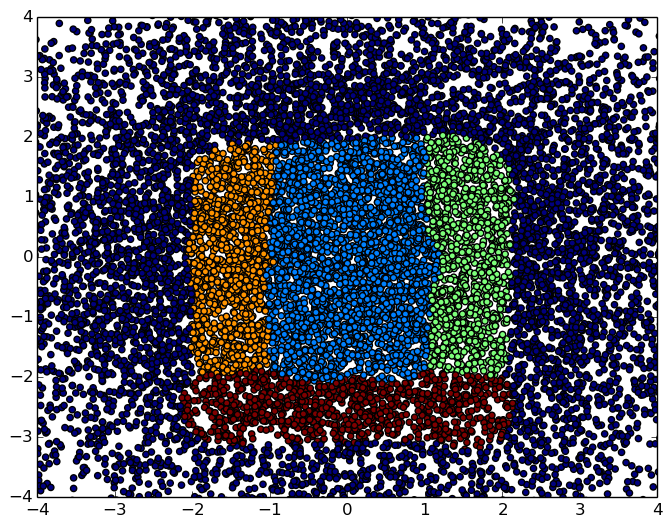

PyObject <matplotlib.collections.PathCollection object at 0x7fa62d9d5290>

In [8]:
using PyPlot

xx=zeros(Float64,length(y_test),1)
yy=zeros(Float64,length(y_test),1)
color=zeros(Int64,length(y_test),1)
for i in 1:length(y_test)
    xx[i] = Rxy[1,i]
    yy[i] = Rxy[2,i]
    color[i] = y_pred[i]
end

ax = gca() # get current axes
ax[:set_xlim]((-4,4));
ax[:set_ylim]((-4,4));
scatter(xx, yy, c=color)